In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  786M    1 9463k    0     0  9463k      0  0:01:25 --:--:--  0:01:25 16.4M
  5  786M    5 43.5M    0     0  43.5M      0  0:00:18  0:00:01  0:00:17 27.8M
  7  786M    7 60.5M    0     0  30.2M      0  0:00:25  0:00:02  0:00:23 23.6M
 11  786M   11 88.4M    0     0  29.4M      0  0:00:26  0:00:03  0:00:23 24.8M
 16  786M   16  129M    0     0  32.3M      0  0:00:24  0:00:04  0:00:20 28.3M
 19  786M   19  153M    0     0  30.6M      0  0:00:25  0:00:05  0:00:20 28.7M
 22  786M   22  179M    0     0  29.9M      0  0:00:26  0:00:06  0:00:20 27.2M
 26  786M   26  211M    0     0  30.2M      0  0:00:25  0:00:07  0:00:18 30.2M
 31  786M   31  250M    0     0  31.2M      0  0:00:25  0:00:08  0:00:17 32.3M
 35  786M   35  282M    0     0  31.3M      0  0:00

In [5]:
!tar -xf kagglecatsanddogs_3367a.zip
!dir

 Volume in drive C has no label.
 Volume Serial Number is AEDA-A44E

 Directory of C:\Users\BRUT4LxD\Desktop\python-projects\computer-vision-projects

05/10/2021  09:05 PM    <DIR>          .
05/10/2021  09:05 PM    <DIR>          ..
05/10/2021  08:56 PM             1,928 .gitignore
05/10/2021  08:58 PM    <DIR>          .ipynb_checkpoints
05/10/2021  09:00 PM       824,894,548 kagglecatsanddogs_3367a.zip
05/10/2021  08:52 PM             8,357 Mnist.ipynb
02/10/2017  10:55 AM            35,545 MSR-LA - 3467.docx
05/10/2021  09:05 PM    <DIR>          PetImages
05/10/2021  08:56 PM                33 README.md
02/10/2017  10:51 AM               104 readme[1].txt
05/10/2021  09:02 PM             4,492 Untitled.ipynb
               7 File(s)    824,945,007 bytes
               4 Dir(s)  581,366,333,440 bytes free


In [4]:
!dir PetImages

 Volume in drive C has no label.
 Volume Serial Number is AEDA-A44E

 Directory of C:\Users\BRUT4LxD\Desktop\python-projects\computer-vision-projects\Cats&Dogs\PetImages

05/10/2021  09:05 PM    <DIR>          .
05/10/2021  09:05 PM    <DIR>          ..
02/10/2017  11:01 AM    <DIR>          Cat
02/10/2017  11:12 AM    <DIR>          Dog
               0 File(s)              0 bytes
               4 Dir(s)  579,721,269,248 bytes free


In [5]:
# filter out corrupted images

import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


In [9]:
# Generate a Dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


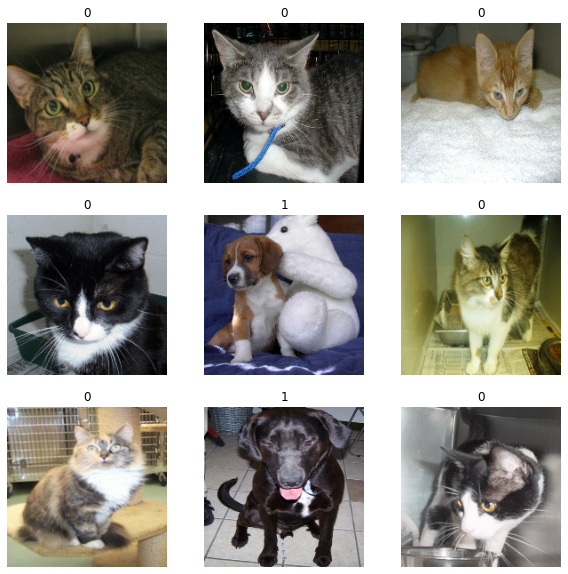

In [12]:
# Visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
# Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

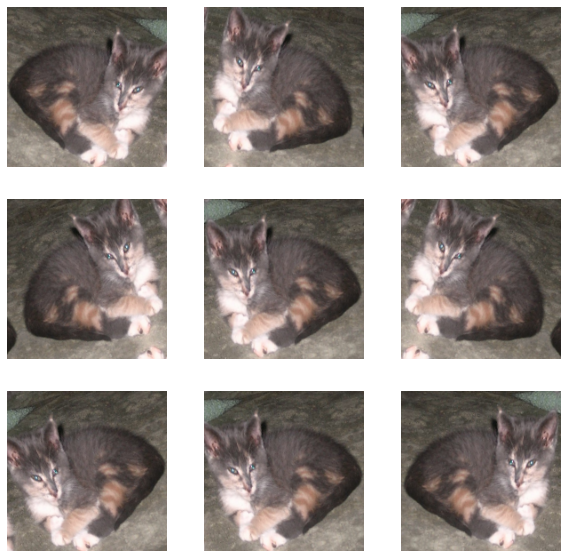

In [14]:
# Visualize augmented images

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
# Configure the dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [17]:
# Make Xception model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [19]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
# Train the model

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

Epoch 1/50
586/586 [==============================] - 96s 146ms/step - loss: 0.6268 - accuracy: 0.6622 - val_loss: 0.5619 - val_accuracy: 0.7190
Epoch 2/50


c:\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


586/586 [==============================] - 82s 141ms/step - loss: 0.4810 - accuracy: 0.7693 - val_loss: 0.4353 - val_accuracy: 0.7921
Epoch 3/50
586/586 [==============================] - 82s 141ms/step - loss: 0.3985 - accuracy: 0.8205 - val_loss: 0.7914 - val_accuracy: 0.7003
Epoch 4/50
586/586 [==============================] - 82s 140ms/step - loss: 0.3297 - accuracy: 0.8555 - val_loss: 0.4425 - val_accuracy: 0.8277
Epoch 5/50
586/586 [==============================] - 82s 140ms/step - loss: 0.2781 - accuracy: 0.8824 - val_loss: 0.2563 - val_accuracy: 0.8933
Epoch 6/50
586/586 [==============================] - 83s 141ms/step - loss: 0.2423 - accuracy: 0.8974 - val_loss: 0.1997 - val_accuracy: 0.9204
Epoch 7/50
586/586 [==============================] - 84s 143ms/step - loss: 0.2102 - accuracy: 0.9117 - val_loss: 0.3394 - val_accuracy: 0.8719
Epoch 8/50
586/586 [==============================] - 82s 140ms/step - loss: 0.1962 - accuracy: 0.9162 - val_loss: 0.2070 - val_accuracy: 0.9

In [28]:
import sys
from PIL import Image
sys.modules['Image'] = Image 
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.